<a id='top'></a>

#Forest Cover Type Prediction

Submitted by:
* Juanjo Carin
* Tuhin Mahmud
* Vamsi Sakhamuri

Date: July 16, 2015

Kaggle Competition hosted at https://www.kaggle.com/c/forest-cover-type-prediction

##Contents

* <a href='#Objectives'>Objectives: Use cartographic variables to classify forest categories</a>

* <a href='#Loading_and_preparing_the_data'>Loading and preparing the data</a>

* <a href='#k-Nearest_Neighbors'>k-Nearest Neighbors (kNN)</a>

* <a href='#Decision_Trees'>Decision Trees</a>

* <a href='#Random_Forests'>Random Forests</a>

* <a href='#SVM'>Support Vector Machines</a>

* <a href='#SGD'>SGD: Stochastic Gradient Descent</a>

* <a href='#Log_Regression'>Logistic Regression</a>

* <a href='#GMM'>Gaussian Mixture Model</a>

* <a href='#Results'>Results</a>

* <a href='#Annex_1'>Annex 1: Naive Bayes (NB)</a>

* <a href='#Annex_2'>Annex 2: Plotting the training dataset</a>

* <a href='#Annex_3'>Annex 3: Feature analysis</a>


<a id='Objectives'></a>

##Objectives: Use cartographic variables to classify forest categories

<a href='#top'>[Back to top]</a>

Random forests? Cover trees? Not so fast, computer nerds. We're talking about the real thing.

In this competition we are asked to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

<a id='Loading_and_preparing_the_data'></a>

##Loading and preparing the data

<a href='#top'>[Back to top]</a>

First we import the libraries we'll use along this project.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.grid_search import RandomizedSearchCV
from sklearn.mixture import GMM
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier 

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature preprocessing.
from sklearn import preprocessing

# SK-learn libraries for dimensionality reduction.
from sklearn.decomposition import PCA

# Data analysis and plotting 
import pandas as pd
import seaborn as sns
from scipy import stats

Next we load the training and test data sets.

In [2]:
ff = "train.csv"
f = open(ff)
column_names = f.readline()

data = np.loadtxt(f, delimiter=",")

y, X = data[:, -1].astype('u1'), data[:, :-1]

ff_test = "test.csv" # you will need to edit this directory
f_test = open(ff_test)
column_names_test = f_test.readline() # you'd needs this ordinarily

data_test = np.loadtxt(f_test, delimiter=",")

# note there are no labels here!
X_test = data_test

print 'The test dataset contains {0} observations with {1} features each.'.\
    format(X_test.shape[0], X_test.shape[1])
print '\t(The 1st one is not really a feature but an observation ID.)'
print 'The training dataset contains {0} observations with the same {1} features each.'.\
    format(X.shape[0], X.shape[1])
print 'For this training set we know the corresponding category (forest cover type) of the ' \
      '{0} observations.'.format(y.shape[0])

The test dataset contains 565892 observations with 55 features each.
	(The 1st one is not really a feature but an observation ID.)
The training dataset contains 15120 observations with the same 55 features each.
For this training set we know the corresponding category (forest cover type) of the 15120 observations.


Note that the test set is about 37 times larger than the training set.

To evaluate our performance, we'll split the training set in 2 subsets: **training** data (90%) plus **development** (aka **validation**) data (10%). **Test** data *must not* be used to validate our models, otherwise we might introduce bias: the more times we look at the error rate on the test set , the more we know about the test data, and the more we include our knowledge (that's very specific to that test data set) in the way we solve the problem.

> Nonetheless, in most cases we'll use *cross-validation* to assess how the results of one model generalize to another data set: with this model validation technique, the training data are partitioned into complementary subsets, multiple rounds of cross-validation are performed using different partitions, and the results are averaged.

We also discard the 1st variable (ID), which does not provide any information about the forest cover type.

In [3]:
# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, y = X[shuffle], y[shuffle]

# Split into train (90%) and dev (10%)
train_size = int(X.shape[0] * 0.9)
# Also discard 1st feature (ID number that doesn't provide info about the label)
y_train, X_train = y[:train_size], X[:train_size, 1:]
y_dev, X_dev = y[train_size:], X[train_size:, 1:]
X_test = X_test[:, 1:]
print X_dev.shape, X_train.shape

(1512L, 54L) (13608L, 54L)


The first 10 features of each observation (`Elevation` to `Horizontal_Distance_To_Fire_Points`) are continuous, with different ranges, while the remaining 44 are all binary. 4 of those 44 binary features correspond to `Wilderness Area` (i.e., there are 4 possible types), so any observation will have one 1 and three 0's in those columns. The last 40 features correspond to `Soil Type` (i.e., there are 40 possible types), so any observation will have one 1 and thirty-nine 0's in those columns.

The type of `Wilderness Area` is roughly uniformly distributed among the observations in the training set, with the exception of the 2nd type (only 3.3%).

`Soil Type` is not uniformly distributed at all: many types are quite uncommon, while others account for up to 14.1% of the cases.

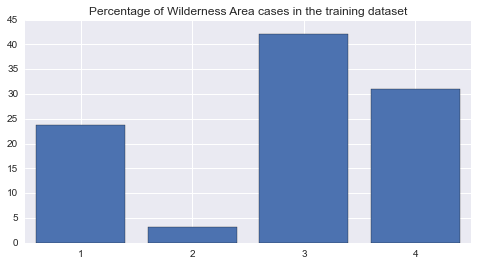

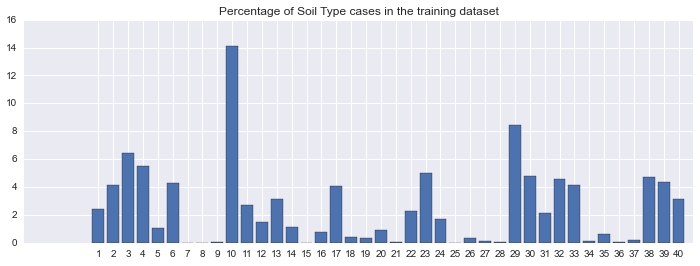

In [4]:
prop_wilderness = 100*X_train[:,10:14].sum(axis=0)/X_train[:,10:14].sum()
prop_soil = 100*X_train[:,14:54].sum(axis=0)/X_train[:,14:54].sum()

plt.figure(figsize=(8, 4))
plt.bar(np.arange(4), prop_wilderness, align="center")
plt.title("Percentage of Wilderness Area cases in the training dataset")
plt.xticks(np.arange(4), np.array([str(i) for i in np.arange(1,5)]))

plt.figure(figsize=(12, 4))
plt.bar(np.arange(40), prop_soil, align="center")
plt.title("Percentage of Soil Type cases in the training dataset")
plt.xticks(np.arange(40), np.array([str(i) for i in np.arange(1,41)]))

plt.show()

For the 10 continuous features we tried `preprocessing.StandardScaler` (to standardize themby removing the mean and scaling to unit variance) as well as `preprocessing.MinMaxScaler` (to standardize them by scaling each feature to a given range; [0,1] in our case, to make it comparable to the binary features).

http://scikit-learn.org/stable/modules/preprocessing.html

In [5]:
# Scale to range [0,1]
    # Only the continuous features
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = np.copy(X_train)
X_dev_minmax = np.copy(X_dev)
X_test_minmax = np.copy(X_test)
X_train_minmax[:, :10] = min_max_scaler.fit_transform(X_train[:, :10])
X_dev_minmax[:, :10]  = min_max_scaler.transform(X_dev[:, :10])
X_test_minmax[:, :10] = min_max_scaler.transform(X_test[:, :10])

# Scale to mean = 0, sd = 1
std_scaler = preprocessing.StandardScaler()
# X_train_std = std_scaler.fit_transform(X_train)
# X_dev_std = std_scaler.transform(X_dev)
# X_test_std = std_scaler.transform(X_test)
    # Only the continuous features
X_train_std = np.copy(X_train)
X_dev_std = np.copy(X_dev)
X_test_std = np.copy(X_test)
X_train_std[:, :10] = std_scaler.fit_transform(X_train[:, :10])
X_dev_std[:, :10] = std_scaler.transform(X_dev[:, :10])
X_test_std[:, :10] = std_scaler.transform(X_test[:, :10])

<a id='k-Nearest_Neighbors'></a>

##k-Nearest Neighbors (kNN)

<a href='#top'>[Back to top]</a>


Because of the different nature of the 54 features (some continuous, some binary and mutually exclusive), we started creating our own distance metric that accounts for these differences to give similar weight to all the features. This new metric combined Euclidean and a variant of Hamming distance, and used the re-scaled version of the continuous variables, as explained in the code below. 

But the results were slightly worse than using the standard Euclidean distance, and after several tests, we discovered that the 44 binary features do not add too much information about the Cover Type. Using that standard Euclidean distance with unscaled data, with all features or just the 10 continuous ones, yields the best results.

The code below just shows some of the results we found.

In [7]:
# Create a mixed distance metric that accounts for the different characteristic of the features
    # to give a similar weight to all of them
# First 10 features are continuous. The square of differences is applied to the values scaled 
    # to [0,1] (maximum value of the sum = 10)
# Last 44 features correspond to 2 features (wilderness area and soil type), with 4 and 40
    # categories each. A variant of Hamming distance is applied to them, so the maximum value
    # is 2 if two observations differ in both features
# The total distance is the square of the sum of those 12 values, divided by the square of 12,
    # so the maximum distance between any two observations will be 1
# The ranges of the first 10 features may vary in the dev and test datasets, so the distances
    # might be slightly greater than 1
def mixed_distance(x, y):
    return np.sqrt(np.sum((x[:10]-y[:10])**2) + 0.5*np.sum(x[10:14]!=y[10:14]) +
                          0.5*np.sum(x[14:54]!=y[14:54]))/np.sqrt(12)

for k in [1, 3, 5]:
    kNN_mixed = KNeighborsClassifier(n_neighbors=k, metric=mixed_distance)
    kNN_mixed.fit(X_train_minmax, y_train)
    print kNN_mixed.score(X_dev_minmax, y_dev)
    
    kNN_mixed.fit(X_train, y_train)
    print kNN_mixed.score(X_dev, y_dev)
    
    kNN = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    kNN.fit(X_train, y_train)
    print kNN.score(X_dev, y_dev)
    
    kNN.fit(X_train[:,:10], y_train)
    print kNN.score(X_dev[:,:10], y_dev)

0.837962962963
0.853835978836
0.853835978836
0.853835978836
0.820767195767
0.832010582011
0.832010582011
0.832010582011
0.801587301587
0.81746031746
0.81746031746
0.81746031746


In [8]:
####TO BE DELETED?

k=8
kNN = KNeighborsClassifier(n_neighbors=k, metric='euclidean')

kNN.fit(X_train_minmax, y_train)
print 'Accuracy using k = {0} neighbor(s) and scaled-to-range data: {1:.4f}'.\
    format(k, kNN.score(X_dev_minmax, y_dev))

kNN.fit(X_train, y_train)
print 'Accuracy using k = {0} neighbor(s) and non-scaled data:      {1:.4f}'.\
    format(k, kNN.score(X_dev, y_dev))

Accuracy using k = 8 neighbor(s) and scaled-to-range data: 0.7917
Accuracy using k = 8 neighbor(s) and non-scaled data:      0.7956


1


(0, 11)

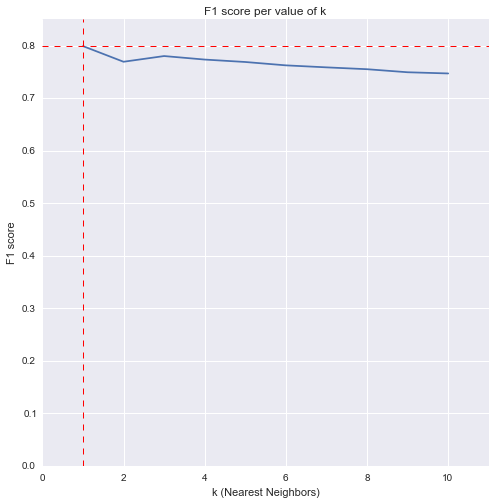

In [9]:
# Estimate by cross-validation the optimal number of neighbors (k)
    # Try between 1 and the number of features (54)
k = {'n_neighbors': np.concatenate([np.arange(1, X_train_minmax.shape[1]+1)]).tolist()}
k = {'n_neighbors': np.concatenate([np.arange(1, 10+1)]).tolist()}
best_param_kNN = GridSearchCV(KNeighborsClassifier(), k, scoring='f1_macro')
best_param_kNN = GridSearchCV(KNeighborsClassifier(), k, scoring='accuracy')
best_param_kNN.fit(X_train_minmax, y_train)
optimal_k = best_param_kNN.best_params_['n_neighbors']
print optimal_k

f1_vector = np.array([best_param_kNN.grid_scores_[x][1] for x in 
                      range(len(k['n_neighbors']))])
plt.figure(figsize=(8, 8))
plt.plot(k['n_neighbors'], f1_vector, marker='x')
plt.axvline(x=optimal_k, linewidth=1, linestyle='--', color='red')
plt.axhline(y=best_param_kNN.best_score_, linewidth=1, linestyle='--', color='red')
plt.xlabel("k (Nearest Neighbors)")
plt.ylabel("F1 score")
plt.title('F1 score per value of k')
plt.ylim([0, (np.ceil(best_param_kNN.best_score_*20)+1)/20])
plt.xlim([0, len(k['n_neighbors'])+1])

How well does our first model perform on the development data?

In [10]:
k = optimal_k
kNN = KNeighborsClassifier(n_neighbors=k)

kNN.fit(X_train, y_train)
print 'Accuracy using k = {0} neighbor(s) and non-scaled data:      {1:.4f}'.\
    format(k, kNN.score(X_dev, y_dev))
print metrics.accuracy_score(y_true=y_dev, y_pred=kNN.predict(X_dev))

kNN.fit(X_train_std, y_train)
print 'Accuracy using k = {0} neighbor(s) and standardized data:    {1:.4f}'.\
    format(k, kNN.score(X_dev_std, y_dev))

kNN.fit(X_train_minmax, y_train)
print 'Accuracy using k = {0} neighbor(s) and scaled-to-range data: {1:.4f}'.\
    format(k, kNN.score(X_dev_minmax, y_dev))

Accuracy using k = 1 neighbor(s) and non-scaled data:      0.8538
0.853835978836
Accuracy using k = 1 neighbor(s) and standardized data:    0.8201
Accuracy using k = 1 neighbor(s) and scaled-to-range data: 0.8380


Which are the cover types most commonly misclassified?

In [10]:
kNN = KNeighborsClassifier(n_neighbors=1)
kNN.fit(X_train[:, :10], y_train)
predicted_y_dev = kNN.predict(X_dev[:, :10])
print classification_report(y_dev, predicted_y_dev)
# Confusion Matrix
CM = metrics.confusion_matrix(y_dev, predicted_y_dev)
CM_percentage = np.around(100*CM.astype('f2') / CM.sum(axis=1)[:, np.newaxis], 1)

# plt.figure(figsize=(12, 12))
# ax = plt.gca()
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)
# ax.axis('off')
# table2 = plt.table(cellText=CM_percentage,rowLabels=np.arange(1,8),
#                            colLabels=np.arange(1,8),loc='center')
# plt.show()

# Print a table with the confusion matrix (percentages of row, so each row correspond to the
    # true cover type, and the diagonal values correspond to the Recall / 100
cover_type = [c.rjust(5) for c in map(str, np.unique(y_dev))]
print "|    |{}|{}|{}|{}|{}|{}|{}|".format(*cover_type)
print '------------------------------------------------'
table = []
for i,j in enumerate(np.unique(y_dev)):
    table.append([j, CM_percentage[i,0], CM_percentage[i,1], CM_percentage[i,2],
                  CM_percentage[i,3], CM_percentage[i,4], CM_percentage[i,5],
                  CM_percentage[i,6]])
for i in table:
    print "|{:4}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|".format(*i)
print

             precision    recall  f1-score   support

          1       0.80      0.67      0.73       220
          2       0.72      0.66      0.69       208
          3       0.85      0.81      0.83       220
          4       0.94      0.96      0.95       212
          5       0.89      0.96      0.93       227
          6       0.83      0.91      0.87       206
          7       0.90      0.99      0.95       219

avg / total       0.85      0.85      0.85      1512

|    |    1|    2|    3|    4|    5|    6|    7|
------------------------------------------------
|   1| 67.3| 18.6|  0.0|  0.0|  4.1|  0.5|  9.5|
|   2| 16.3| 66.3|  5.8|  0.0|  6.7|  3.8|  1.0|
|   3|  0.0|  1.8| 80.9|  5.5|  0.5| 11.4|  0.0|
|   4|  0.0|  0.0|  1.9| 96.2|  0.0|  1.9|  0.0|
|   5|  0.0|  3.1|  0.0|  0.0| 96.5|  0.4|  0.0|
|   6|  0.0|  0.5|  7.3|  0.5|  1.0| 90.8|  0.0|
|   7|  0.9|  0.0|  0.0|  0.0|  0.0|  0.0| 99.1|



The cover types most typically misclassified are 1 and 2 (confused with each other).

<a id='Decision_Trees'></a>

##Decision Trees

<a href='#top'>[Back to top]</a>

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression.

Motivation for using the decision trees for our dataset
* The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.
* Able to handle both numerical and categorical data.

Specially being able to handle both numeric and catergorical data something that suits our purpose since we have both of them in our data.


In [11]:
%%time 
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_dev_dec = dt.predict(X_dev)
print metrics.classification_report(y_dev, y_dev_dec)
print metrics.accuracy_score(y_dev, y_dev_dec)


             precision    recall  f1-score   support

          1       0.72      0.67      0.69       220
          2       0.67      0.64      0.65       208
          3       0.75      0.72      0.74       220
          4       0.96      0.92      0.94       212
          5       0.89      0.89      0.89       227
          6       0.75      0.85      0.80       206
          7       0.92      0.95      0.93       219

avg / total       0.81      0.81      0.81      1512

0.80753968254
Wall time: 356 ms


<a id='Random_Forests'></a>

##Random Forests
<a href='#top'>[Back to top]</a>

Given how closely decision trees can fit themselves to their training data, they have a tendency to overfit. One way of avoiding this is a technique called random forests, in which we build multiple decision trees and let them vote on how to classify inputs:

**Random forests** are ensembles of decision trees. *Multiple decision trees* are trained and aggregated to form a model that is more performant than any of the individual trees. This general idea is the purpose of ensemble learning.

In [12]:
%%time
# Train and predict with the random forest classifier
rf = ensemble.RandomForestClassifier()
rf.fit(X_train,y_train)
y_dev_rf = rf.predict(X_dev)
print metrics.classification_report(y_dev, y_dev_rf)
print metrics.accuracy_score(y_dev, y_dev_rf)

             precision    recall  f1-score   support

          1       0.74      0.74      0.74       220
          2       0.77      0.67      0.72       208
          3       0.77      0.84      0.80       220
          4       0.97      0.96      0.96       212
          5       0.90      0.92      0.91       227
          6       0.82      0.81      0.82       206
          7       0.92      0.95      0.93       219

avg / total       0.84      0.84      0.84      1512

0.842592592593
Wall time: 209 ms


###Improved results with parameter tunning 


In [13]:
%%time
# Train and predict with the random forest classifier
rf = ensemble.RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)
rf.fit(X_train,y_train)
y_dev_rf = rf.predict(X_dev)
print metrics.classification_report(y_dev, y_dev_rf)
print metrics.accuracy_score(y_dev, y_dev_rf)

             precision    recall  f1-score   support

          1       0.82      0.76      0.79       220
          2       0.84      0.71      0.77       208
          3       0.85      0.80      0.82       220
          4       0.96      0.98      0.97       212
          5       0.89      0.94      0.91       227
          6       0.80      0.91      0.85       206
          7       0.92      0.97      0.94       219

avg / total       0.87      0.87      0.87      1512

0.867724867725
Wall time: 6.19 s


###Engineering New Features

In [28]:
#Computes the coordinate distance to hydrology based on horizontal and vertical distance to hydrology

distance_to_hydrology = metrics.euclidean_distances(X_train[:,(3,4)], np.array([0,0]))

X_train_new = np.append(X_train,distance_to_hydrology,axis=1)
X_train_new_del = np.delete(X_train_new,[3,4],axis=1)

distance_to_hydrology = metrics.euclidean_distances(X_dev[:,(3,4)], np.array([0,0]))

X_dev_new = np.append(X_dev,distance_to_hydrology,axis=1)
X_dev_new_del = np.delete(X_dev_new,[3,4],axis=1)

## Random Forest with engineered feature

In [29]:
# update X_train_new with 10 squared columns of continous variables
# Train and predict with the random forest classifier
firstTen=[0,1,2,3,4,5,6,7,8,9]
X_10sq = np.square((X_train[:,firstTen]))
X_sum=np.sum(X_10sq,axis=1)

X_train_tmp=np.delete(X_train,firstTen,axis=1)
X_train_10sq=np.hstack((X_10sq,X_train_tmp))
X_sum=np.reshape(X_sum,(X_sum.shape[0],1))
X_train_10sq=np.hstack((X_train_10sq,X_sum))


firstTen=[0,1,2,3,4,5,6,7,8,9]
X_10sq = np.square((X_dev[:,firstTen]))
X_sum=np.sum(X_10sq,axis=1)
X_dev_tmp=np.delete(X_dev,firstTen,axis=1)
X_dev_10sq=np.hstack((X_10sq,X_dev_tmp))
X_sum=np.reshape(X_sum,(X_sum.shape[0],1))
X_dev_10sq=np.hstack((X_dev_10sq,X_sum))


In [55]:
%%time
rf = ensemble.RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)
rf.fit(X_train_10sq,y_train)
y_dev_rf = rf.predict(X_dev_10sq)
print metrics.classification_report(y_dev, y_dev_rf)
print metrics.accuracy_score(y_dev, y_dev_rf)

rf = ensemble.RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)
rf.fit(X_train_new,y_train)
y_dev_rf = rf.predict(X_dev_new)
print metrics.classification_report(y_dev, y_dev_rf)
print metrics.accuracy_score(y_dev, y_dev_rf)

             precision    recall  f1-score   support

          1       0.80      0.79      0.80       220
          2       0.85      0.69      0.76       208
          3       0.86      0.82      0.84       220
          4       0.96      0.98      0.97       212
          5       0.89      0.94      0.91       227
          6       0.83      0.94      0.88       206
          7       0.94      0.96      0.95       219

avg / total       0.88      0.88      0.87      1512

0.876322751323
             precision    recall  f1-score   support

          1       0.82      0.78      0.80       220
          2       0.83      0.69      0.75       208
          3       0.86      0.80      0.83       220
          4       0.96      0.98      0.97       212
          5       0.88      0.93      0.90       227
          6       0.81      0.93      0.86       206
          7       0.93      0.98      0.95       219

avg / total       0.87      0.87      0.87      1512

0.869708994709
Wall time:

##Adaboost

In [30]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=500, learning_rate=1)
abc.fit(X_train_new, y_train)
y_pred = abc.predict(X_dev_new)
print 'Accuracy (adaboost with decision trees NORMAL new feature):', abc.score(X_dev_new,y_dev)
print classification_report(y_dev,y_pred)

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=500, learning_rate=1)
abc.fit(X_train_new_del, y_train)
y_pred = abc.predict(X_dev_new_del)
print 'Accuracy (adaboost with decision trees NORMAL new feature):', abc.score(X_dev_new_del,y_dev)
print classification_report(y_dev,y_pred)

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=500, learning_rate=1)
abc.fit(X_train, y_train)
y_pred = abc.predict(X_dev)
print 'Accuracy (adaboost with decision trees NORMAL):', abc.score(X_dev,y_dev)
print classification_report(y_dev,y_pred)

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=500, learning_rate=1)
abc.fit(X_train_minmax, y_train)
y_pred = abc.predict(X_dev_minmax)
print 'Accuracy (adaboost with decision trees MINMAX):', abc.score(X_dev_minmax,y_dev)
print classification_report(y_dev,y_pred)

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=500, learning_rate=1)
abc.fit(X_train_std, y_train)
y_pred = abc.predict(X_dev_std)
print 'Accuracy (adaboost with decision trees STD):', abc.score(X_dev_std,y_dev)
print classification_report(y_dev,y_pred)


Accuracy (adaboost with decision trees NORMAL new feature): 0.890211640212
             precision    recall  f1-score   support

          1       0.85      0.77      0.81       220
          2       0.82      0.75      0.78       208
          3       0.88      0.85      0.86       220
          4       0.99      0.99      0.99       212
          5       0.93      0.96      0.94       227
          6       0.84      0.94      0.89       206
          7       0.92      0.98      0.95       219

avg / total       0.89      0.89      0.89      1512

Accuracy (adaboost with decision trees NORMAL new feature): 0.888888888889
             precision    recall  f1-score   support

          1       0.83      0.78      0.81       220
          2       0.84      0.73      0.78       208
          3       0.86      0.85      0.86       220
          4       0.98      0.99      0.98       212
          5       0.92      0.95      0.94       227
          6       0.85      0.93      0.89       20

In [31]:
## try the AdaBoostClassifier with continuous features squared
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=500, learning_rate=1)
abc.fit(X_train_new, y_train)
y_pred = abc.predict(X_dev_new)
print 'Accuracy (adaboost with decision trees NORMAL new feature):', abc.score(X_dev_new,y_dev)
print classification_report(y_dev,y_pred)

## try the AdaBoostClassifier with continuous features squared 
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=500, learning_rate=1)
abc.fit(X_train_10sq, y_train)
y_pred = abc.predict(X_dev_10sq)
print 'Accuracy (adaboost with decision trees NORMAL new feature):', abc.score(X_dev_10sq,y_dev)
print classification_report(y_dev,y_pred)

Accuracy (adaboost with decision trees NORMAL new feature): 0.893518518519
             precision    recall  f1-score   support

          1       0.85      0.77      0.81       220
          2       0.83      0.75      0.79       208
          3       0.88      0.85      0.87       220
          4       0.98      0.99      0.98       212
          5       0.93      0.96      0.95       227
          6       0.85      0.95      0.89       206
          7       0.92      0.99      0.95       219

avg / total       0.89      0.89      0.89      1512

Accuracy (adaboost with decision trees NORMAL new feature): 0.896825396825
             precision    recall  f1-score   support

          1       0.85      0.79      0.82       220
          2       0.84      0.74      0.79       208
          3       0.88      0.86      0.87       220
          4       0.99      0.99      0.99       212
          5       0.92      0.96      0.94       227
          6       0.86      0.96      0.91       20

###Correlation Coefficient computation among the 10 continuous variables

In [58]:
corr = np.corrcoef(X_train[:,:10],rowvar=0)
print corr


[[ 1.         -0.01066166 -0.30976787  0.41489371  0.12099139  0.57919425
   0.09439298  0.21468397  0.09123772  0.44042803]
 [-0.01066166  1.          0.02848089  0.0423883   0.05773633  0.06722229
  -0.59359672  0.32373581  0.63495654 -0.04996831]
 [-0.30976787  0.02848089  1.         -0.05539862  0.26947617 -0.27787165
  -0.20193476 -0.61296147 -0.32501223 -0.23884907]
 [ 0.41489371  0.0423883  -0.05539862  1.          0.65020674  0.2043274
  -0.03430888  0.07898178  0.08075275  0.1594474 ]
 [ 0.12099139  0.05773633  0.26947617  0.65020674  1.          0.01339058
  -0.09415837 -0.13545141 -0.03871485 -0.01388649]
 [ 0.57919425  0.06722229 -0.27787165  0.2043274   0.01339058  1.
  -0.00309174  0.24137396  0.17407255  0.48393795]
 [ 0.09439298 -0.59359672 -0.20193476 -0.03430888 -0.09415837 -0.00309174
   1.         -0.01201619 -0.78009902  0.07618644]
 [ 0.21468397  0.32373581 -0.61296147  0.07898178 -0.13545141  0.24137396
  -0.01201619  1.          0.61299403  0.12414188]
 [ 0.0912

### Random Forest with Cross validation

CHECK

In [59]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.cross_validation import cross_val_score
#clf = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)
#scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='mean_absolute_error', n_jobs=-1)
#print "RandomForestClassifier -> cross validation accuracy: mean = %0.3f std = %0.3f" % (np.mean(scores), np.std(scores))

<a id='SVM'></a>

##Support Vector Machines

<a href='#top'>[Back to top]</a>


In [22]:
kernel = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
best_svm = GridSearchCV(SVC(), kernel, scoring='accuracy')
best_svm.fit(X_train_minmax, y_train)
best_svm.score(X_dev_minmax, y_dev)
best_svm.best_params_

svm = SVC(kernel = best_svm.best_params_['kernel'])
svm.fit(X_train_minmax, y_train)
svm_preds = svm.predict(X_dev_minmax)
print metrics.accuracy_score(y_dev, svm_preds)
print classification_report(y_dev, svm_preds)

0.718915343915
             precision    recall  f1-score   support

          1       0.64      0.73      0.68       220
          2       0.72      0.57      0.63       208
          3       0.58      0.56      0.57       220
          4       0.82      0.86      0.84       212
          5       0.79      0.83      0.81       227
          6       0.61      0.65      0.63       206
          7       0.88      0.82      0.85       219

avg / total       0.72      0.72      0.72      1512



In [23]:
param_grid = {'C': [1, 10, 100, 1000], 'gamma': [0, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
best_svm = GridSearchCV(SVC(), param_grid, scoring='accuracy')
best_svm.fit(X_train_minmax, y_train)
best_svm.score(X_dev_minmax, y_dev)
best_svm.best_params_

svm = SVC(kernel = best_svm.best_params_['kernel'], C=best_svm.best_params_['C'],
          gamma=best_svm.best_params_['gamma'])
svm.fit(X_train_minmax, y_train)
svm_preds = svm.predict(X_dev_minmax)
print metrics.accuracy_score(y_dev, svm_preds)
print classification_report(y_dev, svm_preds)

0.816798941799
             precision    recall  f1-score   support

          1       0.79      0.71      0.75       220
          2       0.77      0.68      0.72       208
          3       0.72      0.73      0.73       220
          4       0.91      0.94      0.93       212
          5       0.86      0.89      0.88       227
          6       0.74      0.79      0.77       206
          7       0.91      0.96      0.93       219

avg / total       0.81      0.82      0.81      1512



<a id='SGD'></a>

##SGD-Stochastic Gradient Descent

<a href='#top'>[Back to top]</a>


CHECK

In [26]:
sgd_clf = linear_model.SGDClassifier()
sgd_clf.fit(X_train, y_train)
y_dev_sgd= sgd_clf.predict(X_dev)
print metrics.classification_report(y_dev, y_dev_sgd)
print metrics.accuracy_score(y_dev, y_dev_sgd)


             precision    recall  f1-score   support

          1       0.00      0.00      0.00       220
          2       0.16      0.99      0.27       208
          3       0.43      0.19      0.26       220
          4       0.81      0.14      0.23       212
          5       0.61      0.16      0.25       227
          6       0.00      0.00      0.00       206
          7       0.00      0.00      0.00       219

avg / total       0.29      0.21      0.15      1512

0.206349206349


<a id='Log_Regression'></a>

##Logistic Regression

<a href='#top'>[Back to top]</a>


In [27]:

#Using training data scaled to 0 -> 1 

logR = LogisticRegression(penalty='l2',C=10)
logR.fit(X_train_minmax, y_train)
y_pred = logR.predict(X_dev_minmax)

print "### Using training data scaled to 0 -> 1 ###\n"

#print metrics.f1_score(y_dev, y_pred, average='macro')
print classification_report(y_dev,y_pred)
# Confusion Matrix
CM = metrics.confusion_matrix(y_dev, y_pred)
CM_percentage = np.around(100*CM.astype('f2') / CM.sum(axis=1)[:, np.newaxis], 1)

#Regular data
logR = LogisticRegression(penalty='l2',C=10)
logR.fit(X_train, y_train)
y_pred = logR.predict(X_dev)

print "### Regular data ###\n"
#print metrics.f1_score(y_dev, y_pred, average='macro')
print classification_report(y_dev,y_pred)
# Confusion Matrix
CM = metrics.confusion_matrix(y_dev, y_pred)
CM_percentage = np.around(100*CM.astype('f2') / CM.sum(axis=1)[:, np.newaxis], 1)

#Using training data scaled to mean 0 and variance 1
logR = LogisticRegression(penalty='l2',C=10)
logR.fit(X_train_std, y_train)
y_pred = logR.predict(X_dev_std)

print "### Using training data scaled to mean 0 and variance 1 ###"
#print metrics.f1_score(y_dev, y_pred, average='macro')
print classification_report(y_dev,y_pred)
# Confusion Matrix
CM = metrics.confusion_matrix(y_dev, y_pred)
CM_percentage = np.around(100*CM.astype('f2') / CM.sum(axis=1)[:, np.newaxis], 1)

### Using training data scaled to 0 -> 1 ###

             precision    recall  f1-score   support

          1       0.67      0.67      0.67       220
          2       0.63      0.56      0.59       208
          3       0.53      0.55      0.54       220
          4       0.83      0.84      0.84       212
          5       0.66      0.73      0.69       227
          6       0.55      0.52      0.54       206
          7       0.87      0.85      0.86       219

avg / total       0.68      0.68      0.68      1512

### Regular data ###

             precision    recall  f1-score   support

          1       0.67      0.64      0.65       220
          2       0.61      0.53      0.57       208
          3       0.52      0.46      0.49       220
          4       0.81      0.85      0.83       212
          5       0.66      0.71      0.69       227
          6       0.53      0.60      0.56       206
          7       0.84      0.87      0.86       219

avg / total       0.66    

<a id='GMM'></a>

##Gaussian Mixture Model

<a href='#top'>[Back to top]</a>


In [7]:
best_covar_type = ''
best_numcomp = 0
dev_accuracy = 0
for cov in ['spherical', 'diag', 'tied', 'full']:
    for comp in range(20,200,20):
        logprob = np.empty(len(np.unique(y_train))*X_dev.shape[0]).\
            reshape(len(np.unique(y_train)), X_dev.shape[0])
        for i,label in enumerate(np.unique(y_train)):
            gmm = GMM(n_components=comp, covariance_type=cov)
            gmm.fit(X_train[y_train==label])
            logprob[i, :] = gmm.score(X_dev)
        preds = logprob.argmax(axis=0) + 1
        acc = metrics.accuracy_score(y_dev, preds)
        if acc > dev_accuracy:
            dev_accuracy = acc
            best_numcomp = comp
            best_covar_type =  cov
print dev_accuracy, best_numcomp, best_covar_type

0.839285714286 180 tied


In [32]:
logprob = np.empty(len(np.unique(y_train))*X_dev.shape[0]).\
            reshape(len(np.unique(y_train)), X_dev.shape[0])
for i,label in enumerate(np.unique(y_train)):
    gmm = GMM(n_components=best_numcomp, covariance_type=best_covar_type)
    gmm.fit(X_train[y_train==label])
    logprob[i, :] = gmm.score(X_dev)
preds = logprob.argmax(axis=0) + 1
print metrics.classification_report(y_dev, preds)

             precision    recall  f1-score   support

          1       0.75      0.72      0.73       220
          2       0.74      0.70      0.72       208
          3       0.79      0.76      0.78       220
          4       0.96      0.88      0.92       212
          5       0.92      0.93      0.92       227
          6       0.74      0.88      0.80       206
          7       0.93      0.95      0.94       219

avg / total       0.83      0.83      0.83      1512



In [ ]:
logprob = np.empty(len(np.unique(y_train))*X_test.shape[0]).\
            reshape(len(np.unique(y_train)), X_test.shape[0])
for i,label in enumerate(np.unique(y_train)):
    gmm = GMM(n_components=best_numcomp, covariance_type=best_covar_type)
    gmm.fit(X_train[y_train==label])
    logprob[i, :] = gmm.score(X_test)
preds = logprob.argmax(axis=0) + 1
print preds

<a id='Results'></a>

##Results

<a href='#top'>[Back to top]</a>


Here's what we need to send back to Kaggle:

In [ ]:
kNN = KNeighborsClassifier(n_neighbors=1)
kNN.fit(X_train, y_train)
preds = kNN.predict(X_test)
print preds

Finally we'd  need to save the output to a textfile, and upload the results to kaggle (see https://www.kaggle.com/c/digit-recognizer/data for further information).

In [ ]:
test_lab_f = open("test_labeled.csv", "w") # you will need to edit this directory

test_lab_f.write("Id,Cover_Type")

idx = X.shape[0]
                 
for pp in preds:
    idx += 1
    test_lab_f.write("\n")
    test_lab_f.write(str(idx) + "," + str(int(pp)))
   
test_lab_f.close()

<a id='Annex_1'></a>

##Annex 1: Naive Bayes (NB)

<a href='#top'>[Back to top]</a>


In [6]:
NB_model = GaussianNB()
NB_model.fit(X_train_std[:,:10], y_train)
print NB_model.score(X_dev_std[:,:10], y_dev)
dev_predicted_labels = NB_model.predict(X_dev_std[:,:10])
print 'Accuracy for a Gaussain NB classifier: {0:.3f}.'.\
    format(metrics.accuracy_score(y_true=y_dev, y_pred=dev_predicted_labels))

0.590608465608
Accuracy for a Gaussain NB classifier: 0.591.


<a id='Annex_2'></a>

##Annex 2: Plotting the training dataset

<a href='#top'>[Back to top]</a>


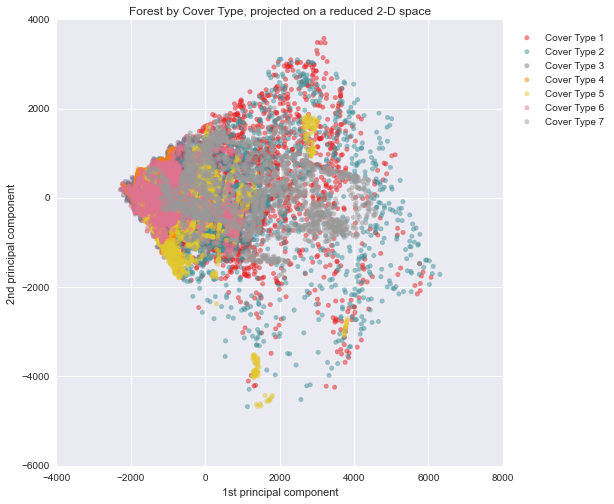

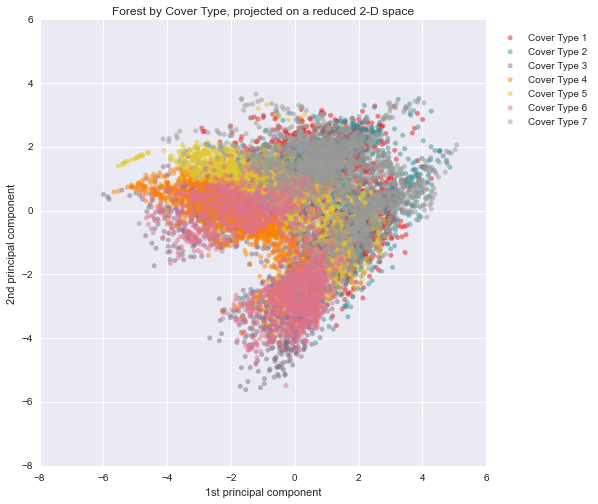

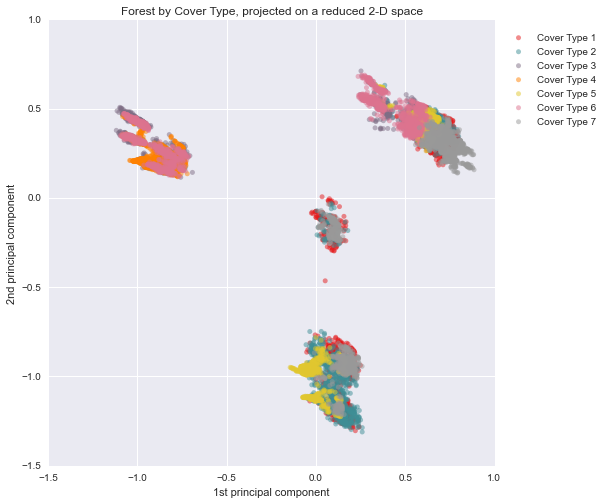

In [25]:
def plot(dataset):
    pc_2 = PCA(n_components=2)
    # Transform the coordinates into this new 2-D space
    X_train_2pc = pc_2.fit_transform(dataset)
    # Plot all elements of the training set in this 2-D space
    # Plot the projection of each forest in a 2-D space, with a color corresponding to each cover
        # type
    Colors = plt.cm.Set1(np.linspace(0, 1, len(np.unique(y_train))))
    # Each color is represented by 4 RGBA coordinates
    # cover_color = np.empty(4*X_train_2pc.shape[0]).reshape(X_train_2pc .shape[0], 4)
    # for i in np.arange(y_train.shape[0]):
        # color_index = y_train[i]-1
        # Each color is indexed by the cover type
        # cover_color[i,:] = Colors[color_index]
    plt.figure  (figsize = (8, 8))
    cover = np.empty(len(np.unique(y_train))).tolist()
    for i in range(len(np.unique(y_train))):
        cover[i] = plt.scatter (X_train_2pc[y_train==i+1,0], X_train_2pc[y_train==i+1,1],
                                c = Colors[i], alpha = 0.5, s=25, edgecolor='',
                                label = 'Cover Type ' + str(i+1))
    plt.xlabel("1st principal component")
    plt.ylabel("2nd principal component")
    plt.title('Forest by Cover Type, projected on a reduced 2-D space')
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=1.)

plot(X_train)
plot(X_train_std)
plot(X_train_minmax)

<a id='Annex_3'></a>

##Annex 3: Feature analysis

<a href='#top'>[Back to top]</a>

Goal of this analysis is to  identify features that we may be able to engineer for better performance and results.

 * From the results of Random Forest Analysis Following comes up as 15 more features that are important
 * Use pairwise feature comparison to try identify correlated features.


15 most important features are

[ 0  5  9  3  4 13  6  1  7  8  2 23 51 10 16]
['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Wilderness_Area4', 'Hillshade_9am', 'Aspect', 'Hillshade_Noon', 'Hillshade_3pm', 'Slope', 'Soil_Type10', 'Soil_Type38', 'Wilderness_Area1', 'Soil_Type3']


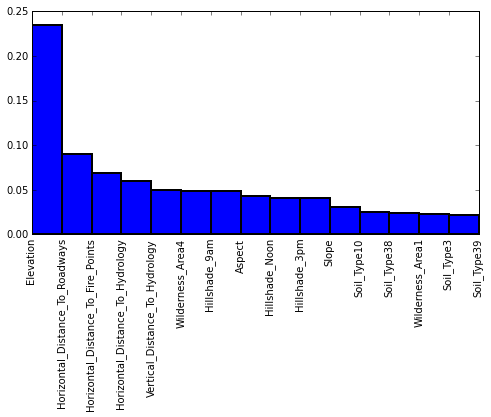

In [15]:
fet_ind=[]
def plot_important_features(rf,nFeatures) :
    global fet_ind
    plt.figure(figsize=(8, 4))
    fet_ind = np.argsort(rf.feature_importances_)[::-1]
    fet_imp = rf.feature_importances_[fet_ind][:nFeatures]
    feature_names = column_names_test.split(",")
    feature_names =feature_names[1:]
    feature_names_array=np.array(feature_names)[fet_ind]
    feature_names=feature_names_array[:nFeatures].tolist()
    
    print "%d most important features are\n" % nFeatures
    print fet_ind[:nFeatures]
    print feature_names
    
    #plot the bar chart for most important features 
    plt.bar(np.arange(len(fet_imp)), fet_imp, width=1, lw=2)
    plt.grid(False)
    xt = np.arange(len(fet_imp)+0.5)
    ax = plt.subplot(111)
    ax.set_xticks(xt)
    xlabels=feature_names_array.tolist()
    ax.set_xticklabels(xlabels, rotation=90)
    plt.xlim(0, len(fet_imp))

plot_important_features(rf,15)

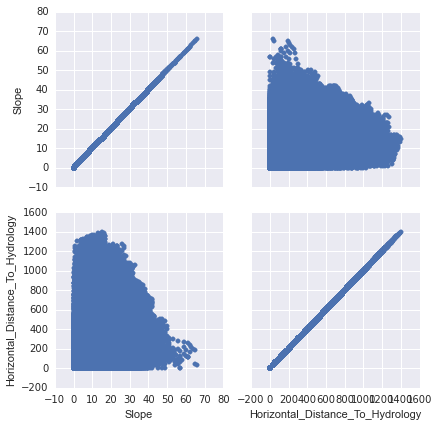

In [23]:
import pandas
df_reduced=df.ix[:,[3,4]]
g=sns.PairGrid(df_reduced)
g.map(plt.scatter)


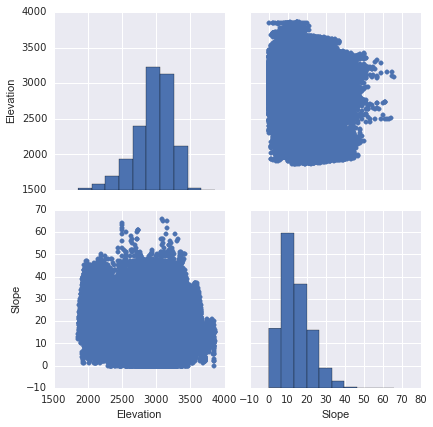

In [24]:
df_reduced=df.ix[:,[1,3]]
g=sns.PairGrid(df_reduced)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);